<a href="https://colab.research.google.com/github/ICPCfirst/DeepLearningHW2/blob/main/HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
import numpy as np

np.random.seed(0)
X_train_fpath = '/content/drive/MyDrive/data/X_train'
Y_train_fpath = '/content/drive/MyDrive/data/Y_train'
X_test_fpath = '/content/drive/MyDrive/data/X_test'
output_fpath = './output_{}.csv'

In [35]:
 # Parse csv files to numpy array
with open(X_train_fpath) as f:        #为了更好关闭文件采用的写法，用来读文件，f指向X_TRAIN。open中的MODE不写，表示只读。
    next(f)                           #next用来迭代，每次向后读一行。这里用来跳过文件的第一行。
    X_train = np.array([line.strip('\n').split(',')[1:] for line in f], dtype = float)   #.strip用来移除字符串首尾指定的字符,split用来以逗号分割句子，
# 得到的结果相当于一个数组，所以后面可以用[1:]来表示下标1及后面的所有元素。for line in f是列表推导式的用法。对于f中的每个LINE都进行前面的操作。
with open(Y_train_fpath) as f:
    next(f)
    Y_train = np.array([line.strip('\n').split(',')[1] for line in f], dtype = float)
with open(X_test_fpath) as f:
    next(f)
    X_test = np.array([line.strip('\n').split(',')[1:] for line in f], dtype = float)
# print('1',X_train.shape)
# print(X_train)
# [[33.  1.  0. ... 52.  0.  1.]
# [63.  1.  0. ... 52.  0.  1.]
# [71.  0.  0. ...  0.  0.  1.]
# ...
# [16.  0.  0. ...  8.  1.  0.]
# [48.  1.  0. ... 52.  0.  1.]
# [48.  0.  0. ...  0.  0.  1.]]

In [36]:
def _normalize(X, train = True, specified_column = None, X_mean = None, X_std = None):
     # 此函数对 X 的特定列进行归一化。
     # 在处理测试数据时，将重复使用训练数据的均值和标准方差。
     #1
     # 参数：
     # X：要处理的数据
     # train: 处理训练数据时为'True'，测试数据时为'False'
     # specific_column：将被规范化的列的索引。 如果“无”，则所有列
     # 将被标准化。
     # X_mean：训练数据的平均值，当train = 'False'时使用
     # X_std：训练数据的标准差，当train = 'False'时使用
     # 输出：
     # X：归一化数据
     # X_mean: 训练数据的计算平均值
     # X_std: 训练数据的计算标准差

    if specified_column == None:
        specified_column = np.arange(X.shape[1])#.shape()中 若参数是空，输出行列。若是0则输出行数。若为1输出列数#np.arrange（x） 用来输出0到x的一个列表。返回列表
    if train:
       # print('1',specified_column.shape)
       # print('2',X.shape)
        X_mean = np.mean(X[:, specified_column], 0).reshape(1, -1) # 压缩行，对各列求均值  转化为一行 把54256行压缩为一行，列数仍为501列
       # print('3',X_mean.shape)
       # X_mean = np.mean(X ,0)
       # print('4',X_mean.shape)
       # X_mean=X_mean.reshape(1, -1)
       # print('5',X_mean.shape)
        X_std  = np.std(X[:, specified_column], 0).reshape(1, -1)
       # print('6',X_std.shape)

    X[:,specified_column] = (X[:, specified_column] - X_mean) / (X_std + 1e-8)  #将列归一化，中心化和标准化处理。
    print('_normaliz',X.shape)
    return X, X_mean, X_std

In [37]:
def _train_dev_split(X, Y, dev_ratio = 0.25):
    # 此函数将数据拆分为训练集和开发集。
    train_size = int(len(X) * (1 - dev_ratio))
    return X[:train_size], Y[:train_size], X[train_size:], Y[train_size:]

In [38]:
# Normalize training and testing data
X_train, X_mean, X_std = _normalize(X_train, train = True)
X_test, _, _= _normalize(X_test, train = False, specified_column = None, X_mean = X_mean, X_std = X_std)# 直接归一化
    
# Split data into training set and development set
dev_ratio = 0.1
X_train, Y_train, X_dev, Y_dev = _train_dev_split(X_train, Y_train, dev_ratio = dev_ratio)

train_size = X_train.shape[0]#
dev_size = X_dev.shape[0]
test_size = X_test.shape[0]
data_dim = X_train.shape[1]
# print("1",train_size)
# print("2",dev_size)
# print("3",test_size)
# print("4",data_dim)
# Size of training set: 48830
# Size of development set: 5426
# Size of testing set: 27622
# Dimension of data: 510

_normaliz (54256, 510)
_normaliz (27622, 510)


In [39]:
def _shuffle(X, Y):  #洗牌，排序
    # 此函数将两个等长的列表/数组 X 和 Y 混在一起。
    randomize = np.arange(len(X))
    np.random.shuffle(randomize)
    return (X[randomize], Y[randomize])    #作用是将行重新打乱。

In [40]:
def _sigmoid(z):            #经典
    # Sigmoid function can be used to calculate probability.
    # To avoid overflow, minimum/maximum output value is set.
    return np.clip(1 / (1.0 + np.exp(-z)), 1e-8, 1 - (1e-8))#np.clip(a,min,max),作用是将所有输出的a都限制在min和max之间。

In [41]:
def _f(X, w, b):
     # 这是逻辑回归函数，由 w 和 b 参数化
     #
     # 论点：
     # X: 输入数据，shape = [batch_size, data_dimension] # 【8，510】
     # w: 权重向量, shape = [data_dimension, ] # 【510，】
     # b: 偏差，标量
     # 输出：
     # X 的每一行被正标记的预测概率，shape = [batch_size, ]
    return _sigmoid(np.matmul(X, w) + b)#二维乘法。  返回n行1列

In [42]:
def _predict(X, w, b):
    # 此函数返回 X 的每一行的真值预测+
    # 通过四舍五入逻辑回归函数的结果。
    return np.round(_f(X, w, b)).astype(np.int)# 这里是取整 取整后容易产生梯度爆炸或溢出，故之后的loss不采用此函数；全精度>混合精度>半精度

In [43]:
def _accuracy(Y_pred, Y_label):# 精度越大越好
    # 这个函数计算预测精度
    acc = 1 - np.mean(np.abs(Y_pred - Y_label))
    return acc   

In [44]:
def _cross_entropy_loss(y_pred, Y_label):
    224 / 5,000
    # 这个函数计算交叉熵。
    #
    # 论点：
    # y_pred：概率预测，浮点向量
    # Y_label：ground truth 标签，布尔向量
    # 输出：
    # 交叉熵，标量
    cross_entropy = -np.dot(Y_label, np.log(y_pred)) - np.dot((1 - Y_label), np.log(1 - y_pred))# np.dot 矩阵乘积
    return cross_entropy


In [45]:
def _gradient(X, Y_label, w, b):
    # 此函数计算交叉熵损失相对于权重 w 和偏差 b 的梯度。
    y_pred = _f(X, w, b)
    pred_error = Y_label - y_pred
    w_grad = -np.sum(pred_error * X.T, 1)  # -E(y_ - y)*X.T T(转置)
    b_grad = -np.sum(pred_error)  #可不可以换成mean
    return w_grad, b_grad


In [63]:
# 初始化权重w和b，令它们都为0
w = np.zeros((data_dim,)) #[0,0,0,...,0]
b = np.zeros((1,))		#[0]

# 训练时的超参数
max_iter = 10
batch_size = 8
learning_rate = 0.2

# 保存每个iteration的loss和accuracy，以便后续画图
train_loss = []
dev_loss = []
train_acc = []
dev_acc = []

# 累计参数更新的次数
step = 1

# 迭代训练
for epoch in range(max_iter):
    # 在每个epoch开始时，随机打散训练数据
    X_train, Y_train = _shuffle(X_train, Y_train) # X_train(54256, 510)  X_test(27622, 510)
    
    # Mini-batch训练
    for idx in range(int(np.floor(train_size / batch_size))): #五万多行平均分，每一份的数据都有八行
        X = X_train[idx*batch_size:(idx+1)*batch_size]    #每一个小batch都有八行，一个epoch有train_size / batch_size)个小batch
        Y = Y_train[idx*batch_size:(idx+1)*batch_size]
        #print(X.shape)
        #print(Y.shape)
        #print("*"*50)

        # 计算梯度
        w_grad, b_grad = _gradient(X, Y, w, b)  # -E(y_ - y)*X.T T(转置)
            
        # 梯度下降法更新
        # 学习率随时间衰减
        w = w - learning_rate/np.sqrt(step) * w_grad # learning_rate/np.sqrt(step) 一会优化成AdaGrad
        b = b - learning_rate/np.sqrt(step) * b_grad

        step = step + 1
            
    # 计算训练集和验证集的loss和accuracy
    y_train_pred = _f(X_train, w, b)
    Y_train_pred = np.round(y_train_pred)
    train_acc.append(_accuracy(Y_train_pred, Y_train))
    train_loss.append(_cross_entropy_loss(y_train_pred, Y_train)/train_size )

    y_dev_pred = _f(X_dev, w, b) # dev 实际要预测的内容
    Y_dev_pred = np.round(y_dev_pred) # 等于_predict函数的内容
    dev_acc.append(_accuracy(Y_dev_pred, Y_dev))
    dev_loss.append(_cross_entropy_loss(y_dev_pred, Y_dev) / dev_size)

print('Training loss: {}'.format(train_loss[-1]))
print('Development loss: {}'.format(dev_loss[-1]))
print('Training accuracy: {}'.format(train_acc[-1]))
print('Development accuracy: {}'.format(dev_acc[-1]))
# print("*"*50)
# print(train_size)
# print(y_train_pred.shape)
# print("*"*50)
# print(y_train_pred)


Training loss: 0.2707008690821554
Development loss: 0.29627523395366184
Training accuracy: 0.8831660864222813
Development accuracy: 0.8754146701068928
48830
(48830,)
**************************************************
[0.01922568 0.46805958 0.13721134 ... 0.10092176 0.02742817 0.0186349 ]


绘图

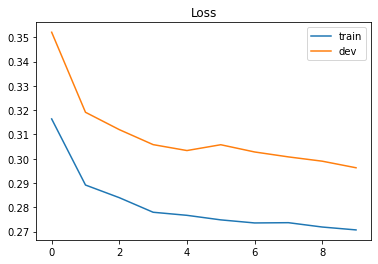

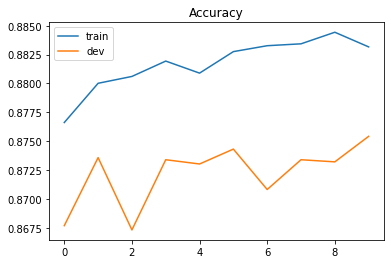

In [64]:
import matplotlib.pyplot as plt

# Loss曲线
plt.plot(train_loss)
plt.plot(dev_loss)
plt.title('Loss')
plt.legend(['train', 'dev'])
plt.savefig('loss.png')
plt.show()

# Accuracy曲线
plt.plot(train_acc)
plt.plot(dev_acc)
plt.title('Accuracy')
plt.legend(['train', 'dev'])
plt.savefig('acc.png')
plt.show()
